In [3]:
import requests
from tqdm import tqdm
from pyspark.sql import SparkSession

In [5]:
# create pyspark session
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [6]:
import requests
from tqdm import tqdm

url = 'https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD'
response = requests.get(url, stream=True)

if response.status_code == 200:
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024  # You can adjust the chunk size as needed.
    
    with open('police-stations.csv', 'wb') as file, tqdm(
        desc='Downloading',
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=chunk_size):
            file.write(data)
            bar.update(len(data))
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

print("Download completed.")

Downloading: 5.57kB [00:00, 5.72MB/s]

Download completed.


In [9]:
ps = spark.read.csv('police-stations.csv', header=True)
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

In [11]:
# only see the disticnt and its names
ps.select('DISTRICT', 'DISTRICT NAME').show(5)

+------------+-------------+
|    DISTRICT|DISTRICT NAME|
+------------+-------------+
|Headquarters| Headquarters|
|          18|   Near North|
|          19|    Town Hall|
|          20|      Lincoln|
|          22|  Morgan Park|
+------------+-------------+
only showing top 5 rows



In [13]:
# read df from reported-crime
from pyspark.sql.functions import to_timestamp, col, lit

df = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))

In [17]:
# for lazy evaluation
from pyspark.sql.functions import count
df.cache()
df.count()

6756594

In [19]:
df.select('District').show(10)

+--------+
|District|
+--------+
|     006|
|     008|
|     019|
|     018|
|     008|
|     004|
|     002|
|     002|
|     025|
|     003|
+--------+
only showing top 10 rows



Here, in the df the district has 4 char and in police its a number, so need to pad

In [21]:
from pyspark.sql.functions import lpad

ps.select(lpad(col('DISTRICT'), 3, '0')).show(20) 

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
|                 004|
|                 005|
|                 006|
|                 007|
|                 008|
|                 009|
|                 010|
|                 011|
|                 012|
|                 ",C|
+--------------------+
only showing top 20 rows



In [22]:
ps = ps.withColumn('Format_district', lpad(col('DISTRICT'), 3, '0'))
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 117

In [23]:
# join df and ps

df.join(ps, df.District == ps.Format_district, 'left_outer').show(5)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+--------+-------------+------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|DISTRICT|DISTRICT NAME|           ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+--------+-----------+-------------------+

In [24]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format_district']

In [25]:
df.join(ps, df.District == ps.Format_district, 'left_outer').drop( 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION').show(5)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+-------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT|DISTRICT NAME|Format_district|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+-------------+---------------+
|11646166|   JC213529|2018-09-01 00:01:00|082XX S INGLESIDE...|0810|             THEFT|           OVER $500|           RESIDENCE| false|    true|0631|     006|   8|            44|      06|2018|04/06/2019 04:04:...|       6|      Gresham| 

### Challenge 2

#### Q1. Whats the most frequently reported noncriminal activity?

In [26]:
df.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [30]:
df.select('Primary Type').distinct().count()

36

Total 36 unique crime type

In [35]:
df.select('Primary Type').distinct().sort(col('Primary Type')).show(36, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

Non Criminal Types:
1. NON - CRIMINAL
2. NON-CRIMINAL
3. NON-CRIMINAL (SUBJECT SPECIFIED)

In [37]:
# get the non-criminal data

nc = df.filter( (col('Primary Type') == 'NON - CRIMINAL') | (col('Primary Type') == 'NON-CRIMINAL') | (col('Primary Type') == 'NON-CRIMINAL (SUBJECT SPECIFIED)') )

nc.select('ID', 'Primary Type', 'Description', 'Date').show(30, truncate=False)

+--------+--------------+-------------------------------------------+-------------------+
|ID      |Primary Type  |Description                                |Date               |
+--------+--------------+-------------------------------------------+-------------------+
|11249289|NON-CRIMINAL  |LOST PASSPORT                              |2016-12-23 12:00:00|
|10813751|NON-CRIMINAL  |LOST PASSPORT                              |2003-03-17 20:00:00|
|10625887|NON-CRIMINAL  |LOST PASSPORT                              |2016-08-02 09:00:00|
|10686750|NON-CRIMINAL  |LOST PASSPORT                              |2016-09-17 10:00:00|
|11397021|NON-CRIMINAL  |LOST PASSPORT                              |2017-10-30 09:00:00|
|11420921|NON-CRIMINAL  |LOST PASSPORT                              |2015-12-13 14:34:00|
|10579978|NON-CRIMINAL  |LOST PASSPORT                              |2015-12-25 09:00:00|
|10422305|NON-CRIMINAL  |LOST PASSPORT                              |2009-02-22 08:00:00|
|10828494|

In [40]:
nc.groupBy('Description').count().orderBy('count', ascending = False).show(10, truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



#### Q2. Which day of weel has most number of reported crime?

In [42]:
from pyspark.sql.functions import date_format

new_df = df.withColumn("day_name", date_format("Date", "EEEE"))

new_df.select('ID', 'Date', 'day_name').show(10, truncate=False)

+--------+-------------------+--------+
|ID      |Date               |day_name|
+--------+-------------------+--------+
|11646166|2018-09-01 00:01:00|Saturday|
|11645836|2016-05-01 00:25:00|Sunday  |
|11243268|2017-01-01 00:01:00|Sunday  |
|1896258 |2001-12-15 02:00:00|Saturday|
|11645527|2015-02-02 10:00:00|Monday  |
|11034701|2001-01-01 11:00:00|Monday  |
|10224881|2015-09-03 18:00:00|Thursday|
|11449702|2018-07-31 13:30:00|Tuesday |
|11645648|2018-01-01 08:00:00|Monday  |
|11241640|2017-10-13 09:00:00|Friday  |
+--------+-------------------+--------+
only showing top 10 rows



In [46]:
new_df.groupBy('day_name').count().orderBy('count', ascending = False).show(1)

+--------+-------+
|day_name|  count|
+--------+-------+
|  Friday|1017437|
+--------+-------+
only showing top 1 row



In [47]:
new_df.groupBy('day_name').count().collect()

[Row(day_name='Wednesday', count=974348),
 Row(day_name='Tuesday', count=968517),
 Row(day_name='Friday', count=1017437),
 Row(day_name='Thursday', count=965089),
 Row(day_name='Saturday', count=965566),
 Row(day_name='Monday', count=953214),
 Row(day_name='Sunday', count=912423)]

In [51]:
# get the day of the week
day_of_week = [x[0] for x in new_df.groupBy('day_name').count().collect()]
day_of_week

['Wednesday', 'Tuesday', 'Friday', 'Thursday', 'Saturday', 'Monday', 'Sunday']

In [52]:
count_of_each_day = [x[1] for x in new_df.groupBy('day_name').count().collect()]
count_of_each_day

[974348, 968517, 1017437, 965089, 965566, 953214, 912423]

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
cp = pd.DataFrame({'Day_of_week' : day_of_week, 'Counts' : count_of_each_day})
cp.head(7)

,Day_of_week,Counts
0,Wednesday,974348
1,Tuesday,968517
2,Friday,1017437
3,Thursday,965089
4,Saturday,965566
5,Monday,953214
6,Sunday,912423


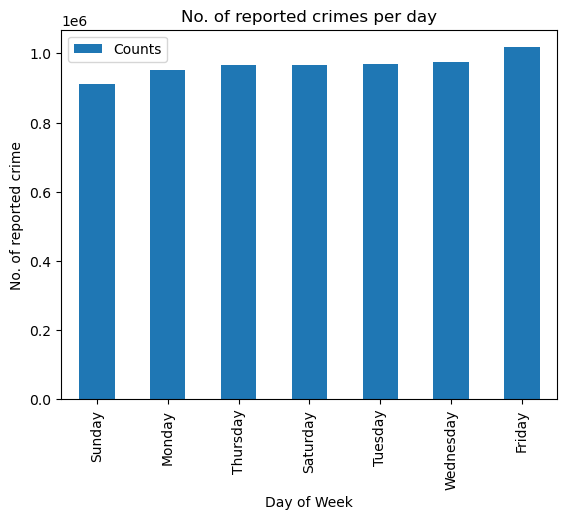

In [56]:
cp.sort_values('Counts').plot(kind = 'bar', x='Day_of_week', y = 'Counts')
plt.xlabel('Day of Week')
plt.ylabel('No. of reported crime')
plt.title('No. of reported crimes per day')
plt.show()